## <center> Machine Learning Programming Exercise 7</center>
# <center> **Partie 2: construction et apprentissage d'un réseau de neurones de classification avec Tensorflow 2.x** </center>

| <font size=6,font color='red'>Monôme / binôme</font> | <font size=6,font color='red'>Nom</font> | <font size=6,font color='red'>Prénom</font> |
|:-------------: |:----------- |:------ |
| binôme 1 | <span style="color:red">DUBEE</span> | <span style="color:red">Melvin</span> |
| binôme 2 | <span style="color:red">ROUDAUT</span> | <span style="color:red">Tanguy</span> |


Nous allons balayer les différentes étapes permettant de réaliser cet objectif:
- Chargement d'un dataset (ici avec tensorflow-dataset mais d'autres méthodes sont possibles)
- Analyse et préparation des données
- Prétraitements des données
- Création du réseau
- Apprentissage en choisissant une fonction de cout, des métriques d'évaluation et un optimiseur.
- Mise en oeuvre et première analyse de l'apprentissage

Vos objectifs sont:
- d'analyser et comprendre les codes quand ils sont fournis
- de les compléter si demander


## 1 - Imports

Pour pouvoir commencer, vous importerez les librairies suivantes:

## 1.1 Colab or not

In [1]:
# common imports
import sys,os,glob

# Colab preamble
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:

  # mount google drive directories
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)


  # ----------- Your code here --------------------->
  # replace the ipynb_name (below) with the name of your jupyter notebook file

  ipynb_name = 'partie2.ipynb'

  # ------------------------------------------------>

  ipynb_name = glob.glob(os.getcwd() + '/gdrive/MyDrive/Machine_Learning/' + ipynb_name, recursive = True)
  code_folder = os.path.dirname(ipynb_name[0])

  # change to the right folder
  %cd "$code_folder"
  !ls

Mounted at /content/gdrive
/content/gdrive/MyDrive/Machine_Learning
partie1.ipynb  partie2.ipynb


## 1.2 Import packages

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



## 2 - Chargement du dataset avec tensorflow-dataset (tfds)

Pour charger les données, nous allons utiliser le projet tensorflow-dataset qui a le mérite de transformer directement les données en objet tf.data.Dataset que je souhaite vous voir utiliser pour différentes raisons exposées en cours. Un grand nombre de projet/framework ou simple fichier excel ou csv peut être utilisé pour importer les données.

Le jeu de données MNIST est d'environ 12 MB et sera téléchargé si il n'est pas trouvé dans le chemin par défaut. Le chemin par défaut est ~/tensorflow_datasets/mnist/3.0.1.

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
                        'mnist',
                        split=['train', 'test'],
                        shuffle_files=True,
                        as_supervised=True,
                        with_info=True,
                        )

# check if data is a tf.data.Dataset object
assert isinstance(ds_train, tf.data.Dataset)
assert isinstance(ds_test, tf.data.Dataset)

print(ds_train)
print(ds_test)

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


## 3 - Analyse et préparation des données avec l'API tf.data.Dataset

Les données ont été chargées et regroupent 70.000 images associées à leur indice de chiffre manuscrit. Le jeu de données est déjà séparé en deux sous-ensembles mutuellement exclusifs.

### 3.1 - Caractéristiques du dataset
Dans cette section, analysez le dictionnaire ds_info pour renseigner les variables ci-dessous
- **Nombre d'exemples dans chaque ensemble**

In [4]:
print(ds_info)

# ----------- Your code here --------------------->

num_examples_train = ds_info.splits['train'].num_examples
num_examples_test =  ds_info.splits['test'].num_examples

# ------------------------------------------------>


print("Size of:")
print("- Training-set:\t\t{}".format(num_examples_train))
print("- Testing-set:\t\t{}".format(num_examples_test))


tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)
Size of:
- Tra

- **Caractéristiques des entrées: dimension, nombre de canaux, nombre de classes, etc**

In [5]:
# ----------- Your code here --------------------->

# shape of one image MNIST
img_shape = ds_info.features["image"].shape[:2] # 2 premiers éléments

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = ds_info.features["image"].shape[-1] # Dernier élément

# Number of classes, one class for each of 10 digits.
num_classes = ds_info.features["label"].num_classes

# ------------------------------------------------>


# Number of classes, one class for each of 10 digits.

#img_nbLin, img_nbCol, img_nbChan = img_shape
#img_size_flat = img_nbLin* img_nbCol

print(ds_info.features["image"])

print(img_shape)
print(num_channels)
print(num_classes)


Image(shape=(28, 28, 1), dtype=uint8)
(28, 28)
1
10


## 3.2 - Consume the dataset


L'API de `tf.data.Dataset` créé un itérable python ce qui le rend facile à utiliser pour obtenir les éléments de la base de données.

Voici comment on récupère le premier élément (il suffit de réexécuter pour le second, troisième, etc.):

In [6]:
# créer explicitement un itérateur Python en utilisant iter
ite = iter(ds_test)

In [7]:
# Prendre le prochain element en consommant ses éléments en utilisant next :
elem = next(ite)
image = elem[0].numpy()
label = elem[1].numpy()

print(image.shape)
print(label)
print(image)



(28, 28, 1)
2
[[[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  

Affichez l'image avec le label correspondant dans le titre



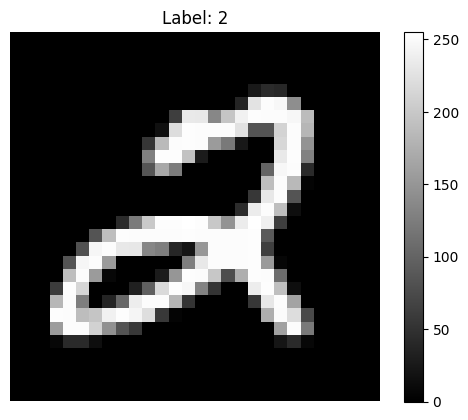

In [8]:
# ----------- Your code here --------------------->
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.colorbar()
plt.show()
# ------------------------------------------------>

## 3.3 - Prétraitement du dataset avec tf.data.Dataset API

L'API `tf.data.Dataset` permet de définir assez simplement des chaînes de traitements efficaces efficient. Ainsi, le schéma classique est :
- la création d'un dataset source à partir des données d'entrée (déjà fait ici);
- la définition et l'application de transformations du datasets pour prétraiter les données;
- l'itération sur le dataset et traiter tous les éléments (consume the dataset).

L'itération fonctionne un peu comme un streaming, de telle manière que le dataset n'a pas besoin de tenir dans la mémoire de l'ordinateur ou dans celle du GPU.

### 3.3.1 - Normaliser tous les éléments
Pour cela, il suffit de créer une fonction `normalize_img` et d'utiliser la méthode `map` de l'objet `tf.data.Dataset`. La sortie représente un autre dataset dans lequel à chaque appel, à chaque itération sur l'objet la fonction `normalize_img` sera appliquée.

In [9]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(normalize_img)
ds_test  = ds_test.map(normalize_img)


Ecrivez quelques commandes pour vérifier que la transformation a été faite.

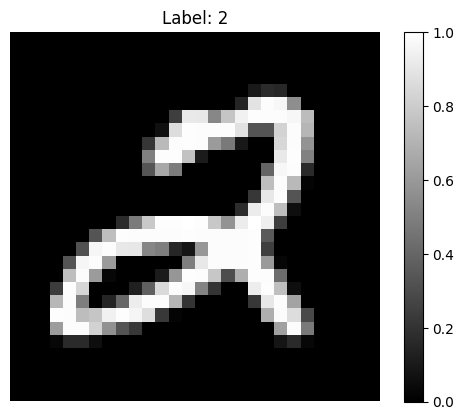

In [10]:
# ----------- Your code here --------------------->
ite = iter(ds_test)
elem = next(ite)
image = elem[0].numpy()
label = elem[1].numpy()

plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.colorbar()
plt.show()

# ------------------------------------------------>


### 3.3.2 - Mélanger les éléments de la base de données
Pour cela, il suffit d'utiliser la méthode `shuffle` de l'objet `tf.data.Dataset`. Il est utile de mélanger les exemples d'apprentissage pour que la méthode de recueil/tri des données n'influence pas l'apprentissage. A noter qu'il est inutile de le faire sur la base de test.

In [11]:
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)


### 3.3.3 - Mise en batch des données

L'apprentissage des réseaux de neurones fonctionne par rétropropragation des gradients. Dans le cas des grandes bases de données, il est préférable de ne pas calculer les gradients sur toute la base de données d'apprentissage car le calcul pourrait être extrêment long et difficile à réaliser algorithmiquement. On préfère évaluer ce gradient sur une petite quantité de données mise en batch (de données). Le calcul des gradients est moins précis mais réalisé beaucoup plus souvent. Ce formalisme donne naissance à l'algorithme de descente de gradient stochastique (SGD). L'appel à la méthode `batch` de tensorflow fait cela.


In [12]:
batch_size = 100
ds_train = ds_train.batch(batch_size, drop_remainder=True)  # drop_remainder=False epresenting whether the last batch should be dropped in the case it has fewer than batch_size elements; the default behavior is not to drop the smaller batch.
ds_test = ds_test.batch(batch_size, drop_remainder=True) # drop_remainder=False epresenting whether the last batch should be dropped in the case it has fewer than batch_size elements; the default behavior is not to drop the smaller batch.


Ecrire quelques lignes de codes pour vérifier qu'on obtient bien un batch de taille `batch_size`

In [13]:
elem = next(iter(ds_test))
image = elem[0].numpy()
label = elem[1].numpy()
print(image.shape)
print(label.shape)


(100, 28, 28, 1)
(100,)


La fonction `plot_images` permet l'affichage de 9 éléments de la base de données. Executez là en changeant l'appel pour coller avec vos variables.

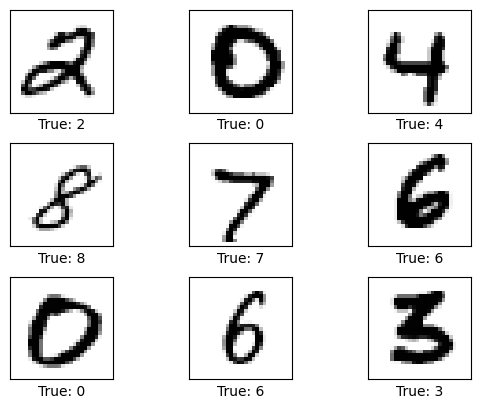

In [14]:
def plot_images(images, target_true, target_pred=None):
    assert images.shape[0] == target_true.shape[0] == 9

    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i, ..., 0], cmap='binary')

        # Show true and predicted classes.
        if target_pred is None:
            xlabel = "True: {0}".format(target_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(target_true[i], target_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

# ----------- Your code here --------------------->

plot_images(image[0:9,...], label[0:9])

# ------------------------------------------------>


## 4 - Créer et analyser le modèle de réseau de neurones avec Keras

La version 2 de Tensorflow intègre désormais Keras (`tf.keras`) facilitant notamment la création d'architecture pour les réseaux de neurones.


### 4.1 Créer un réseau simple

L'architecture d'un réseau de neurones est définie par un empilement de couches de neurones. Dans Keras, un grand nombre de couches est possible ([layers possibles dans tf.keras.layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/)). On les découvrira au fur et à mesure. Dans ce TP, nous allons nous restreindre aux réseaux de neurones qu'on appelle `Dense` ou `fully connected` c'est à dire que tous les neurones d'une couche sont connectés à tous les neurones de la couche suivante.

Cette couche `Dense` implemente l'opération: output = activation(dot(input, kernel) + bias). Cette couche Dense est caractérisée ([lien vers Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)) notamment par:
 - un nombre de neurones de sortie;
 - le type d'activation appliqué à tous les neurones à la sortie;
 - Un aspect important est la méthode d'initialisation des poids et des biais (kernel_initializer, bias_initializer) qu'on explicitera plus tard (cf cours sur l'apprentissage des réseaux de neurones profonds)
 - vous noterez que par défaut il n'y a pas de régularisation.


Comme les entrées ont une structure spatiale (ce sont des images), et que les couches denses ne traitent pas la structure spatiale (nous verrons la semaine prochaine comment on traite les structures spatiales; cf cours sur les CNN), il faut modifier les entrées par une couche appelée `Flatten` chargée de vectoriser les images.

Ainsi, un modèle à une couche dense prenant en entrée des images de shape: img_shape est défini par la fonction `tf.keras.Sequential`. Vous trouverez [ici](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) les différentes méthodes associés avec le modèle créé.


In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=img_shape),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

# deuxième solution équivalente
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Flatten(input_shape=img_shape))
# model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))


### 4.2 Evaluer les performances d'un modèle

Au cours de l'apprentissage, il est important d'évaluer les performances. La boucle d'évaluation suivante permet de faire cela pour l'accuracy. Vous noterez l'utilisation de la boucle sur les données de la base de test et des fonctions `tf.equal` et de `tf.reduce_mean`. Notez également comment appliquer le modèle à un batch d'images (tenseurs).

Quelques questions auxquelles vous devez répondre pour comprendre ce code:
- Combien d'itérations sont réalisées par la boucle for?

La boucle for itère sur un ds_test qui est un batch de 100 donc 100 itérations.

- Quelle est la dimension de target_pred_ohe? Pourquoi? Quel est le nom de ce codage?

La dimension de target_pred_ohe dépend de la taille du batch et du nombre de classes dans notre problème de classification (batch_size, label). Le nom de ce codage est un codage "One-hot encoding". Dans ce codage, chaque classe est représentée par un vecteur binaire unique où tous les éléments sont à zéro, sauf celui qui correspond à la classe réelle, qui est à un.

- Comment est calculée l'accuracy?

target_pred stock l'indice de la classe prédite avec la plus haute probabilité pour chaque exemple dans le batch. correct_prediction permet de comparer à chaque itérations la classe prédite avec la classe réelle, on stock chaque résultat booléen dans un tableau de booléen cor_pred. La dernière étape consiste à calculer la moyenne des booléens à 1 dans le tableau correct_prediction, ce qui veut dire la proportion de bonnes prédictions dans le batch. On enregistre cette moyenne dans un tableau global à chaque itérations. La fonction retournerra la moyenne de ces moyennes du tableau accuracy_tot. On retourne donc l'accuracy (précision) qui est le pourcentage d'exemples dans le batch pour lesquels le modèle a correctement prédit la classe.



In [16]:
# Evaluation des performances du modèle:
#  1- appliquer le modèle pour obtenir les prédictions sur un batch d'images
#  2- évaluer les performances en calculant l'accuracy
#  3- recommencer en épuisant les batchs de données de tests (for loop)


print(len(ds_test));

def eval_loop():

    cor_pred = []
    accuracy_tot = []
    for i_batch, (img, target_label) in enumerate(ds_test):

        # appliquer le modèle (logits = tf.matmul(img, weights) + biases) à un batch d'image
        target_pred_ohe = model(img, training=False)
        # autre possibilité: target_pred_ohe = model.predict(img)

        # Déterminer la classe prédite
        target_pred = tf.argmax(target_pred_ohe, axis=1)

        # performance measures
        correct_prediction = tf.equal(target_pred, target_label)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        cor_pred.append(correct_prediction)
        accuracy_tot.append(accuracy.numpy())

    print('model accuracy: {}'.format(np.mean(accuracy_tot)))

#
eval_loop()


100
model accuracy: 0.09820001572370529


### 4.3 Visualiser les poids du réseau

En supplément de la performance, les poids du modèle peuvent également être représentés.
Cette représentation donne des informations sur ce qui a été appris par la machine.
La fonction `plot_weights` permet de faire cela.

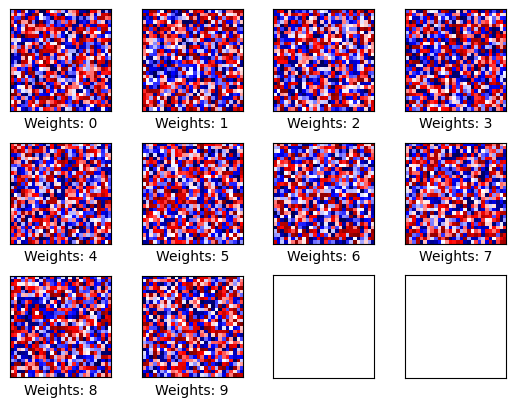

In [17]:
def plot_weights(weights, img_shape):

        # Get the lowest and highest values for the weights.
        # This is used to correct the colour intensity across
        # the images so they can be compared with each other.
        w_min = np.min(weights)
        w_max = np.max(weights)

        # Create figure with 3x4 sub-plots,
        # where the last 2 sub-plots are unused.
        fig, axes = plt.subplots(3, 4)
        fig.subplots_adjust(hspace=0.3, wspace=0.3)

        for i, ax in enumerate(axes.flat):
            # Only use the weights for the first 10 sub-plots.
            if i < 10:
                # Get the weights for the i'th digit and reshape it.
                # Note that w.shape == (img_size_flat, 10)
                image = weights[:, i].reshape(img_shape)

                # Set the label for the sub-plot.
                ax.set_xlabel("Weights: {0}".format(i))

                # Plot the image.
                ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

            # Remove ticks from each sub-plot.
            ax.set_xticks([])
            ax.set_yticks([])

        # Ensure the plot is shown correctly with multiple plots
        # in a single Notebook cell.
        plt.show()




# ----------- Your code here --------------------->
# Get the values for the weights from the TensorFlow variable (méthode get_weights).

weights = model.get_weights()[0]

# ------------------------------------------------>

# visualisation des poids
plot_weights(weights, img_shape[0:2])



Les poids positifs sont rouges et les poids négatifs sont bleus. Ces poids peuvent être intuitivement compris comme des filtres d'images. On verra plus tard l'évolution de ces poids le long de l'apprentissage.


## 5 - Définir la fonction de coût à optimiser

Pour que le modèle puisse mieux classer les images en entrée, nous devons d'une manière ou d'une autre modifier les variables pour les poids et les biais. Pour ce faire, il faut définir une fonction de coût mesurant l'adéquation entre la sortie prédite du modèle et à la sortie souhaitée.

L'entropie croisée est la fonction classiquement utilisée dans la classification pour actualiser les poids. L'objectif de l'optimisation est donc de minimiser l'entropie croisée afin qu'elle soit aussi proche de zéro que possible en modifiant les poids et les biais du modèle. TensorFlow dispose d'une fonction intégrée pour calculer l'entropie croisée. Notez qu'elle utilise les valeurs des logits car il calcule également la softmax en interne.
Vous pouvez vous reporter [ici](https://www.tensorflow.org/api_docs/python/tf/keras/losses) pour voir les différentes fonctions de coût déjà implémentées dans Tensorflow.

Notre modèle calculera le coût à l'aide de la fonction `tf.keras.losses.SparseCategoricalCrossentropy` qui prend les prédictions de probabilité de classe du modèle et l'étiquette souhaitée (codée en entier), et renvoie la perte moyenne à travers les exemples. La fonction calculant les gradients est aussi donnée.

A noter qu'il existe la fonction `tf.keras.losses.CategoricalCrossentropy` qui réalise exactement le même calcul mais à partir de l'étiquette codée en `one-hot`.



In [18]:
loss_fcn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

def loss(model, x, y, training):
    # training=training is needed only if there are layers with different behavior during training versus inference (e.g. Dropout).
    y_ = model(x, training=training)

    return loss_fcn(y_true=y, y_pred=y_)

l = loss(model, image, label, training=False)
print("Loss test: {}".format(l))


 # Utilisez le contexte tf.GradientTape pour calculer les gradients utilisés pour optimiser votre modèle:

def grad(model, inputs, targets):

    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=True)

    return loss_value, tape.gradient(loss_value, model.trainable_variables)





Loss test: 2.3001914024353027


## 6 - Définir la méthode d'optimisation

Maintenant, il s'agit de définir un optimiseur qui va trouver le minimum de la fonction. Nous connaissons maintenant la descente de gradient stochastique qu'il s'agit de définir avec son `learning rate`.

Notez que l'optimisation n'est pas faite à ce stade. En fait, on définit juste la fonction.
Notez également les différents [choix possibles](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) qui seront un peu plus détailler plus tard.



In [19]:
optimizer_fcn = tf.keras.optimizers.SGD(learning_rate=1.0)

def optimize(features, target_labels):

    # Compute the loss and the gradient
    loss_value, grads = grad(model, features, target_labels)

    # mise à jour des paramètres
    optimizer_fcn.apply_gradients(zip(grads, model.trainable_variables))

    return grads


Pour tester cette fonction, nous allons grâce à ce qui a été mis en place auparavant:
- optimiser une fois
- évaluer le nouveau coût (la commande est donnée)
- évaluer les performances
- visualiser les nouveaux poids

Step: 1,         Loss: 2.1394052505493164
model accuracy: 0.1394999921321869


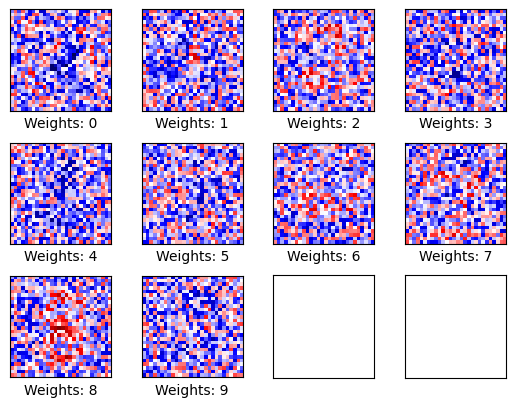

In [20]:
# ----------- Your code here --------------------->

# Get a batch of (images, labels) from the training set use next et itet commands)
(img_batch, label_batch) = next(iter(ds_train))

# Call the optimize function
grads = optimize(img_batch, label_batch)

# Evaluate the loss for each step
print("Step: {},         Loss: {}".format(optimizer_fcn.iterations.numpy(), loss(model, img_batch, label_batch, training=True).numpy()))

# Evaluate the accuracy
eval_loop()

# Visualize the weights of the model
weights = model.get_weights()[0]
plot_weights(weights, img_shape[0:2])

# ------------------------------------------------>


## 7 - Définir la boucle d'apprentissage

### 7.1 - Définir la boucle d'apprentissage avec Tensorflow

Une fois qu'on a défini tous les éléments, la boucle d'apprentissage est très simple.
Elle prend en entrée le nombre d'epochs `num_epochs`.

In [21]:
def train_loop(num_epochs):
    for epoch in range(0, num_epochs, 1):

        # Get a batch of training examples.
        # img_batch now holds a batch of images and
        # label_batch are the true labels for those images.
        (img_batch, label_batch) = next(iter(ds_train))

        # optimize
        optimize(img_batch, label_batch)

        print("Step: {},         Loss: {}".format(optimizer_fcn.iterations.numpy(), loss(model, img_batch, label_batch, training=True).numpy()))



Faites tourner cette fonction pour une epoch et analyser les résultats comme auparavant:
- évaluer le nouveau coût (la commande est donnée)
- évaluer les performances
- visualiser les nouveaux poids


Step: 2,         Loss: 2.6311960220336914
model accuracy: 0.5210999846458435


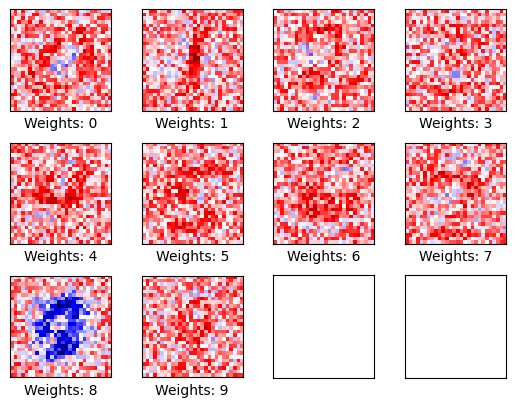

In [22]:
num_epochs = 1


# ----------- Your code here --------------------->

# Call the train loop function
train_loop(num_epochs)

# Evaluate the accuracy
eval_loop()

# Visualize the weights of the model
weights = model.get_weights()[0]
plot_weights(weights, img_shape[0:2])

# ------------------------------------------------>


Refaites tourner cette fonction pour 10 epoch et analyser les résultats comme auparavant:
- évaluer le nouveau coût (la commande est donnée)
- évaluer les performances
- visualiser les nouveaux poids


Step: 3,         Loss: 3.7084836959838867
Step: 4,         Loss: 2.221456289291382
Step: 5,         Loss: 2.338230609893799
Step: 6,         Loss: 2.5809340476989746
Step: 7,         Loss: 2.6238014698028564
Step: 8,         Loss: 2.1509854793548584
Step: 9,         Loss: 0.7189899682998657
Step: 10,         Loss: 0.9568634033203125
Step: 11,         Loss: 0.6979400515556335
Step: 12,         Loss: 0.7179201245307922
model accuracy: 0.6952999830245972


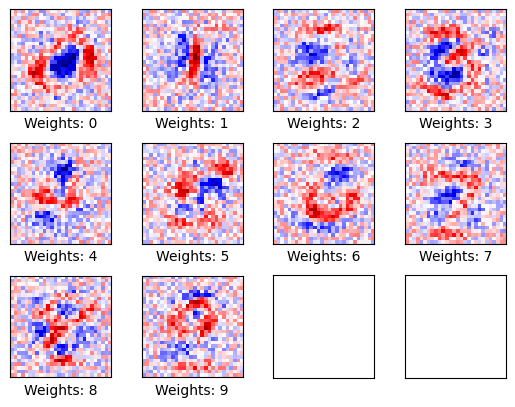

In [23]:
num_epochs = 10


# ----------- Your code here --------------------->

# Call the train loop function
train_loop(num_epochs)

# Evaluate the accuracy
eval_loop()

# Visualize the weights of the model
weights = model.get_weights()[0]
plot_weights(weights, img_shape[0:2])
# ------------------------------------------------>


### 7.2 - Keras offre la possibilité de simplifier la démarche

En fait, l'API Keras facilite le code en intégrant une bonne partie de toutes ces étapes. Après avoir défini, l'architecture du modèle avec `Sequential`. Vous devrez le compiler avec la méthode `compile` en choisissant la fonction de coût, l'optimiseur et la métrique de performance.


In [24]:
model.compile(
              loss=loss_fcn,
              optimizer=optimizer_fcn,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy]
             )


L'apprentissage sur un nombre d'epochs se fera par un simple appel à la méthode `.fit`.
Elle permet de définir un ensemble de validation sur lequel on vient estimer les performances de généralisation.

In [25]:
num_epochs = 100
history = model.fit(ds_train, epochs=num_epochs, validation_data=ds_test)

Epoch 1/100
600/600 [==============================] - 7s 5ms/step - loss: 0.3779 - sparse_categorical_accuracy: 0.8891 - val_loss: 0.2961 - val_sparse_categorical_accuracy: 0.9162
Epoch 2/100
600/600 [==============================] - 4s 4ms/step - loss: 0.3134 - sparse_categorical_accuracy: 0.9109 - val_loss: 0.3312 - val_sparse_categorical_accuracy: 0.9029
Epoch 3/100
600/600 [==============================] - 5s 4ms/step - loss: 0.2999 - sparse_categorical_accuracy: 0.9153 - val_loss: 0.2844 - val_sparse_categorical_accuracy: 0.9165
Epoch 4/100
600/600 [==============================] - 4s 3ms/step - loss: 0.2932 - sparse_categorical_accuracy: 0.9171 - val_loss: 0.2988 - val_sparse_categorical_accuracy: 0.9147
Epoch 5/100
600/600 [==============================] - 4s 3ms/step - loss: 0.2891 - sparse_categorical_accuracy: 0.9185 - val_loss: 0.2913 - val_sparse_categorical_accuracy: 0.9208
Epoch 6/100
600/600 [==============================] - 5s 4ms/step - loss: 0.2858 - sparse_cate

Le modèle peut alors être sauver dans un fichier (selon deux formats) et éventuellement recharger par la suite.

In [26]:
# Saving and Restoring the model
# architecture and weights
model.save("my_keras_model.h5")
model = keras.models.load_model("my_keras_model.h5")

# weights only
model.save_weights("my_keras_weights.ckpt")
model.load_weights("my_keras_weights.ckpt")



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Une fois le modèle appris, la méthode `predict` permet de le prédire sur toutes les données de `ds_test`.

In [27]:
target_pred = model.predict(ds_test) # noter que la méthode target_pred = model(ds_test) ne marche pas

target_label_pred = tf.argmax(target_pred, axis=1).numpy()
print(target_label_pred.shape)

100/100 [==============================] - 1s 4ms/step
(10000,)


## 8 - Analyser les résultats
Une fois le modèle appris, il s'agit de recenser tous les résultats en affichant (et en les commentant!!!!):
 - les learning curves;
 - les métriques de performance;
 - les poids et les gradients;
 - les erreurs de classification.

### 8.1 learning curves and accuracies

Deux possibilités existent pour les métriques de performance:
- soit la méthode `evaluate` de Keras
- soit la fonction `eval_loop()`

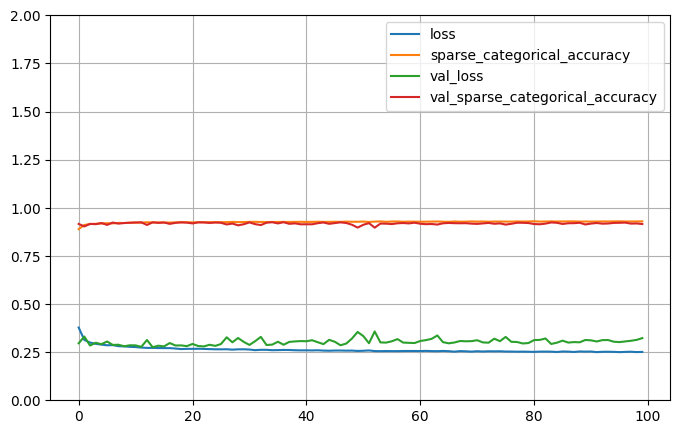

100/100 [==============================] - 1s 5ms/step - loss: 0.3229 - sparse_categorical_accuracy: 0.9155
{'loss': 0.3229363262653351, 'sparse_categorical_accuracy': 0.9154999852180481}


In [28]:
# learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)  # set the vertical range to [0-1]
plt.show()

# métriques de performance:
result = model.evaluate(ds_test)
print(dict(zip(model.metrics_names, result)))





**Question:** Commenter ces métriques de performances?

Sur le graphique, on retrouve les courbes d'apprentissage du modèle. Plus précisement, on a la perte et la précision de prédiction de notre modèle. On distingue quatre courbes, permettant de différencier la perte et et la précision pour l'ensemble d'entrainement de ceux de l'ensemble de test. Ce que l'on peut en dire maintenant c'est que la précision est quand même très bonne avec un peu plus de 91% de bonnes prédictions. Les courbes entre ensemble d'entraînement et ensemble de test pour l'accuracy sont très proches, cela se comporte relativement pareil. Pour les courbes de perte, on voit qu'elles se situent toute deux entre 25% et 33%, le loss prends en compte la magnitude dees erreurs ce qui explique que l'on peut avoir un accuracy de 91% malgré une perte de 25%. On peut en déduire que le modèle classe correctement 3 images sur 4.

## 8.2 - Examiner les poids et les gradients

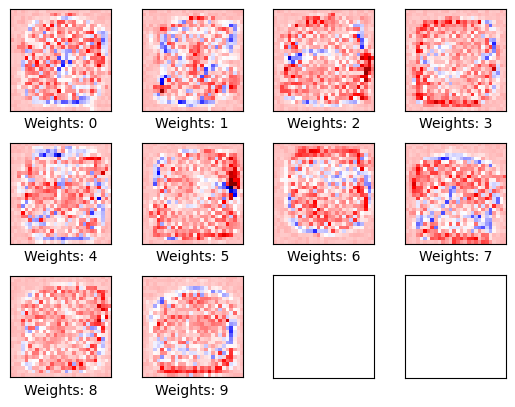

In [29]:
# Visualize the weights of the model
weights = model.get_weights()
weights = weights[0]
plot_weights(weights, img_shape[0:2])


Les poids positifs sont en rouge et en bleu pour les négatifs. Par exemple, les poids utilisés pour déterminer si une image montre un chiffre zéro ont une réaction positive (rouge) à une image d'un cercle, et ont une réaction négative (bleu) aux images dont le contenu se trouve au centre du cercle.

De même, les pondérations utilisées pour déterminer si une image montre un chiffre 1 réagissent positivement (rouge) à une ligne verticale au centre de l'image, et réagissent négativement (bleu) aux images dont le contenu se trouve autour de cette ligne.

Notez que les poids ressemblent surtout aux chiffres qu'ils sont censés reconnaître après quelques itérations. Après un entraînement sur plusieurs milliers d'images, les poids deviennent plus difficiles à interpréter car ils doivent reconnaître de nombreuses variations de la façon dont les chiffres peuvent être écrits.

### 8.3 - Afficher les erreurs de classification


In [30]:
target_pred = model.predict(ds_test)
target_label_pred = tf.argmax(target_pred, axis=1).numpy()


100/100 [==============================] - 0s 3ms/step


**Plotting example errors**

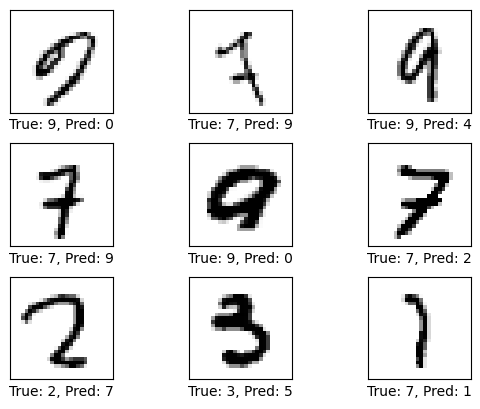

In [31]:
tmp = [target_label_actual for (img, target_label_actual) in ds_test]

target_label_actual = []
[ target_label_actual.extend(el.numpy()) for el in tmp]
target_label_actual = np.array(target_label_actual)

tmp = [img for (img, target_label_actual) in ds_test]
imgs = []
[ imgs.extend(el.numpy()) for el in tmp]
imgs = np.array(imgs)

uncorrect = np.where(target_label_pred != target_label_actual)[0]
uncorrect = uncorrect[0:9] # juste pour le display
plot_images(imgs[uncorrect,:,:,:], target_label_actual[uncorrect], target_pred=target_label_pred[uncorrect])
